In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
import math

df = pd.read_csv('Mall_Customers.csv')
df.head()

,CustomerID,Gender,Age,AnnualIncome(k$),SpendingScore(1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


Из датасета мы сразу уберем метку класса - признаков CustomerID и Gender. Но в конце будем Gender использовать для анализа полученных результатов.

In [97]:
df = df.drop(columns=["CustomerID", "Gender"])


missing_per_col = df.isna().sum()
print("\nВсего пропусков в датасете:", missing_per_col.sum())


Всего пропусков в датасете: 0


Как мы видим в датасете отсутвуют пропуски.

# Дескриптивный анализ

,Признак,Среднее,Медиана,Мода,Асимметрия,Эксцесс,Тест Колмагорова-Смирнова
0,Age,38.85,36.0,32,0.49,-0.67,p=3.188e-02
1,AnnualIncome(k$),60.56,61.5,54,0.32,-0.10,p=6.006e-01
2,SpendingScore(1-100),50.20,50.0,42,-0.05,-0.83,p=3.274e-01


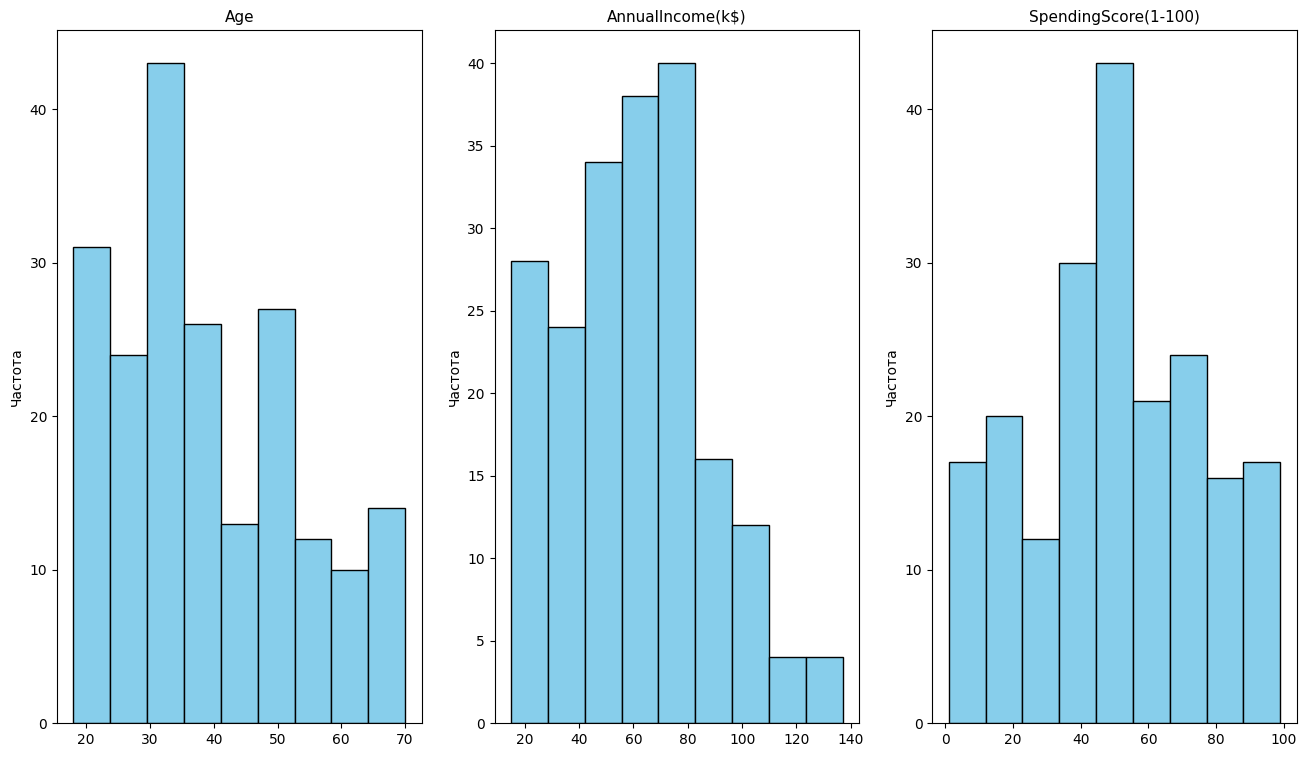

In [98]:
import scipy.stats as stats

n = df.shape[0]
k = int(math.ceil(1 + math.log2(n)))

def interpret_pvalue(p):
     if p > 0.05:
         return "Нормальное"
     elif p > 0.01:
         return "Близко к нормальному"
     else:
         return "Далеко от нормального"
     
features = df.columns
fig, axes = plt.subplots(1, 3, figsize=(16, 9))
axes = axes.flatten()

stat = {
    "Признак": [], "Среднее": [], "Медиана": [], "Мода": [],
    "Асимметрия": [], "Эксцесс": [], "Тест Колмагорова-Смирнова": []
    }

for i, feature in enumerate(features):
    ks_test = stats.kstest(df[feature], 'norm', args=(df[feature].mean(), df[feature].std()))

    stat["Признак"].append(feature)
    stat["Среднее"].append(round(df[feature].mean(), 2))
    stat["Медиана"].append(round(df[feature].median(), 2))
    stat["Мода"].append(round(df[feature].mode()[0], 2))
    stat["Асимметрия"].append(round(df[feature].skew(), 2))
    stat["Эксцесс"].append(round(df[feature].kurtosis(), 2))
    stat["Тест Колмагорова-Смирнова"].append(f"p={ks_test.pvalue:.3e}")


    axes[i].hist(df[feature], bins=k, edgecolor='black', color='skyblue')
    axes[i].set_title(feature, fontsize=11)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("Частота")

display(pd.DataFrame(stat))

# Отбор признаков

## Матрица корреляции

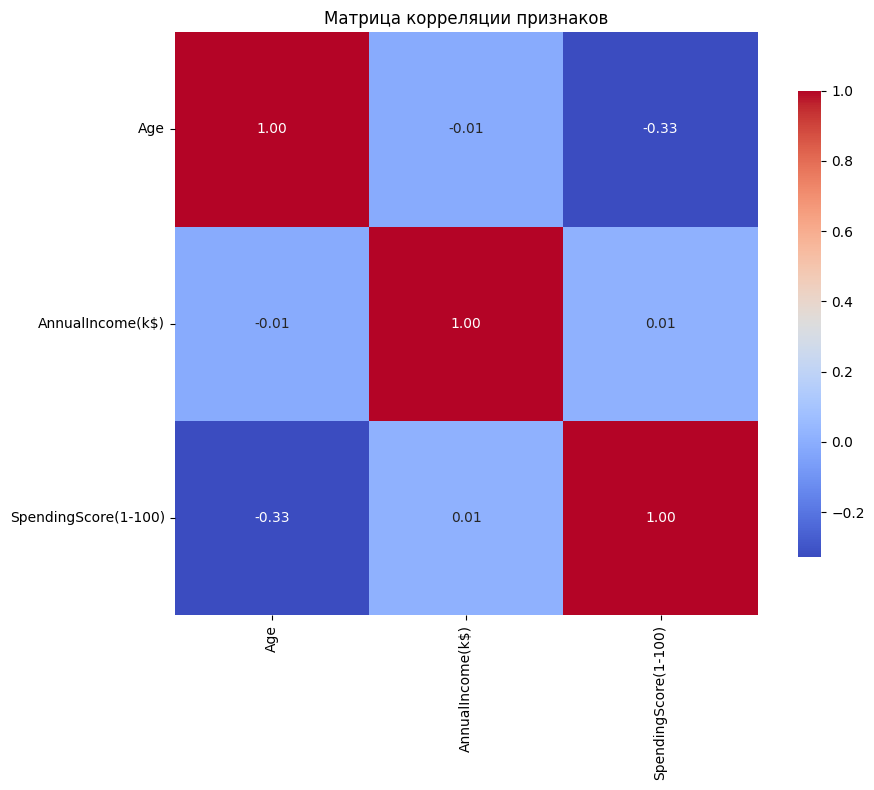

In [99]:
corr = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    square=True,
    cbar_kws={"shrink": 0.8}
)
plt.title("Матрица корреляции признаков")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

На матрице корреляции видно что среди признаков наблюдаются слабые корреляции между собой что говорит что все признаки можно использовать в кластере.

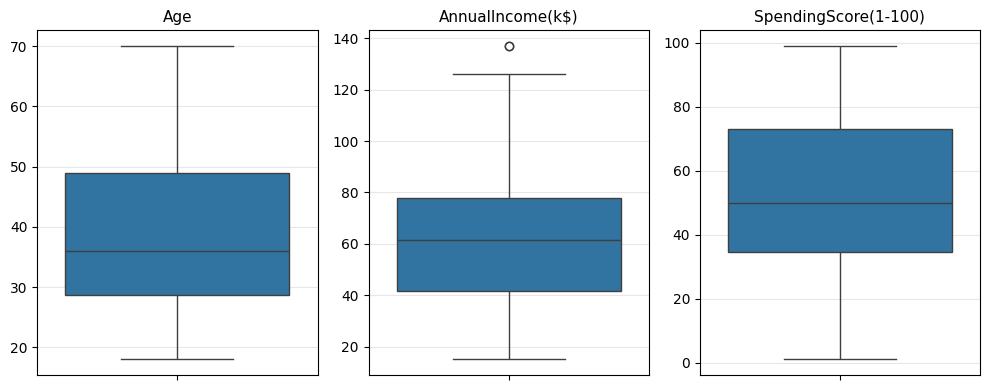

In [100]:
features = df.columns.tolist()
n_features = len(features)

n_cols = 2
n_rows = math.ceil(n_features / n_cols)

fig, axes = plt.subplots(1, 3, figsize=(10, 4))
axes = axes.flatten()

for i, col in enumerate(features):
    ax = axes[i]
    sns.boxplot(
        y= df[col],
        ax=ax
    )
    ax.set_title(col, fontsize=11)
    ax.set_ylabel("")  
    ax.grid(axis="y", alpha=0.3)

for j in range(n_features, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()

На рисунке представлены диаграммы “Ящик с усами”. По ним можно сделать вывод что требуется стандартизация, т.к. значения AnnualIncome(k$) немного больше чем у других

Также на рисунке наблюдаем большое количество выбросов, эти выбросы не аномальны (не являются ошибками измерения). 

В связи с этим будем использовать RobustScaler для стандартизации, 

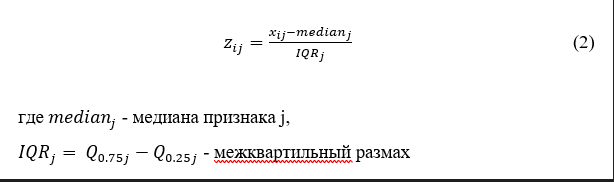


т.к. в отличии от StandardScaler 

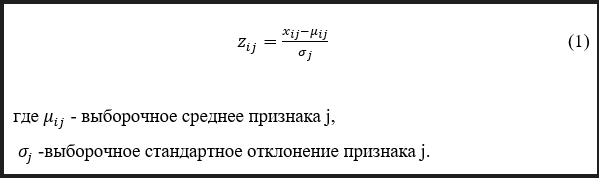

он хорошо справляется с выбросами. Связано это с тем, что StandardScaler использует среднее и стандартное отклонение, которые очень чувствительны к выбросам. 
Для RobustScaler используются медиана и IQR, которые почти не реагируют на выбросы. То есть масштаб задаётся теми наблюдениями, которые находятся внутри ящика, а „усы“ и отдельные точки не ломают масштаб.


## Стандартизация признаков

In [101]:
from sklearn.preprocessing import RobustScaler

X = df.copy()

scaler = RobustScaler()
X_scaled_array = scaler.fit_transform(X)

X_scaled = pd.DataFrame(
    X_scaled_array,
    columns=X.columns,
    index=X.index
)

# Диаграммы рассеивания

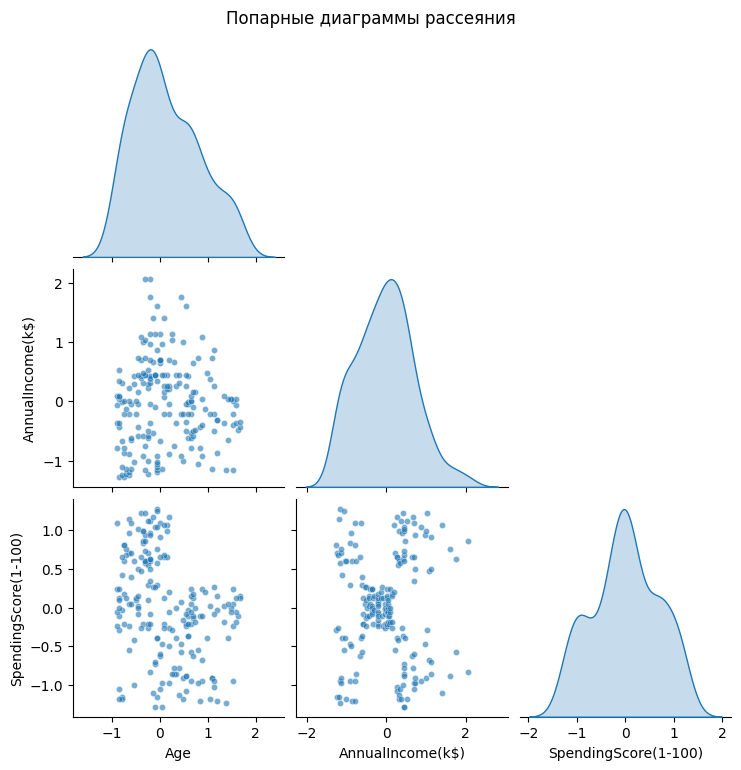

In [102]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
numerical_features = ['Age', 'AnnualIncome(k$)', 'SpendingScore(1-100)']
sns.pairplot(
    X_scaled,
    vars=X_scaled.columns.tolist(),
    diag_kind="kde",
    corner=True,
    plot_kws={"alpha": 0.6, "s": 20}
)
plt.suptitle("Попарные диаграммы рассеяния", y=1.02)
plt.show()

Оценим тип кластерной структуры. 
- У кластеров есть границы между собой.
- кластеры собраны в сферические формы.


В связи с эти для кластерного анализа выбраны следующие методы:
- **K-Mean** – как базовый метод кластеризации.
- **Иерархическая кластеризация** - используется небольшой датасет, на диаграммах визуально можно определить кол-во кластеров

Не берем не рассмотрение следующие методы:
- **GMM**, 
- **DBSCAN**, так как этот метод больше подходит для данных с чёткими плотными областями и разреженными промежутками.

# KMEANs

## Подбор количества кластеров

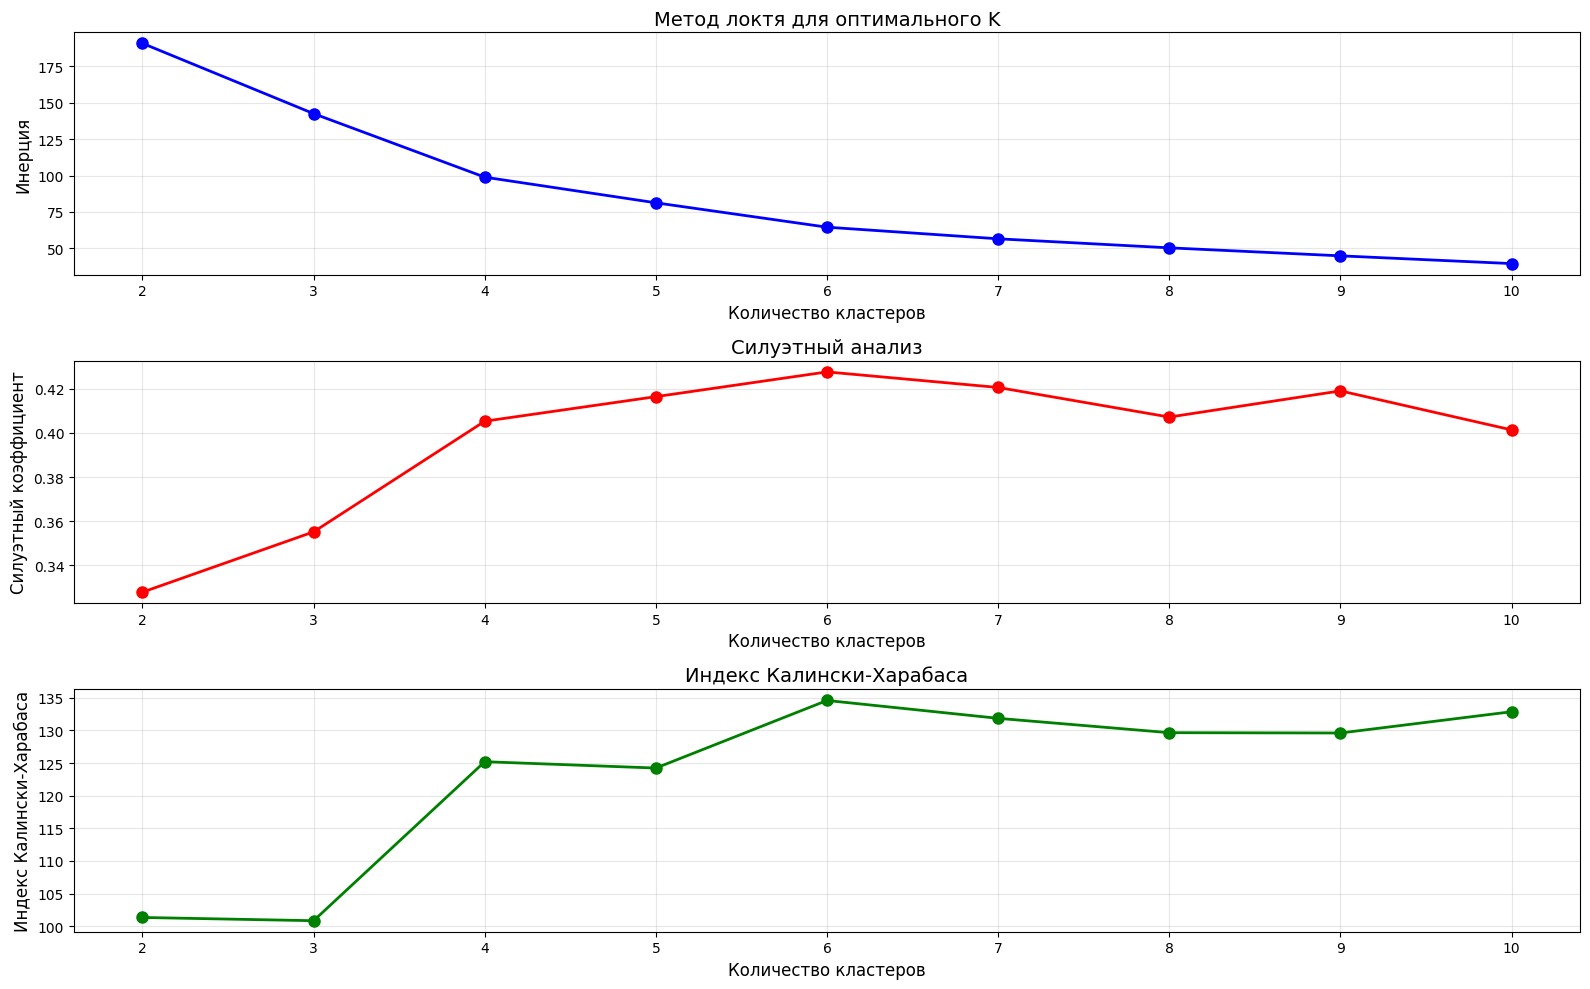

In [103]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.metrics import adjusted_rand_score
import warnings
warnings.filterwarnings('ignore')

if 'Cluster' in X_scaled.columns:
    X_scaled_clustering = X_scaled.drop(columns=['Cluster'])
else:
    X_scaled_clustering = X_scaled.copy()

np.random.seed(42)
n_samples = len(X_scaled_clustering)
true_labels_demo = np.zeros(n_samples, dtype=int)
true_labels_demo[(X_scaled_clustering['Age'] > 0) & (X_scaled_clustering['AnnualIncome(k$)'] > 0)] = 1
true_labels_demo[(X_scaled_clustering['SpendingScore(1-100)'] > 0.5) & (X_scaled_clustering['AnnualIncome(k$)'] < 0)] = 2
true_labels_demo = true_labels_demo % 3  

inertia = []
silhouette_scores = []
calinski_scores = []
davies_scores = []
ari_scores = []  
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=20)
    labels = kmeans.fit_predict(X_scaled_clustering)
    inertia.append(kmeans.inertia_)
    
    silhouette_scores.append(silhouette_score(X_scaled_clustering, labels))
    calinski_scores.append(calinski_harabasz_score(X_scaled_clustering, labels))
    davies_scores.append(davies_bouldin_score(X_scaled_clustering, labels))
    
    ari_scores.append(adjusted_rand_score(true_labels_demo, labels))

fig, axes = plt.subplots(3, 1, figsize=(16, 10))

axes[0].plot(K_range, inertia, 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Количество кластеров', fontsize=12)
axes[0].set_ylabel('Инерция', fontsize=12)
axes[0].set_title('Метод локтя для оптимального K', fontsize=14)
axes[0].grid(True, alpha=0.3)

axes[1].plot(K_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
axes[1].set_xlabel('Количество кластеров', fontsize=12)
axes[1].set_ylabel('Силуэтный коэффициент', fontsize=12)
axes[1].set_title('Силуэтный анализ', fontsize=14)
axes[1].grid(True, alpha=0.3)

axes[2].plot(K_range, calinski_scores, 'go-', linewidth=2, markersize=8)
axes[2].set_xlabel('Количество кластеров', fontsize=12)
axes[2].set_ylabel('Индекс Калински-Харабаса', fontsize=12)
axes[2].set_title('Индекс Калински-Харабаса', fontsize=14)
axes[2].grid(True, alpha=0.3)


plt.tight_layout()
plt.show()

1. Проведем анализ графиков внешних и внутренних метрик. На рисунке представлен график силуэтного анализа. На нем видно, что наивысшее значение достигается при k = 6(0.428).
2. По графику индекса Калински–Харабаса наилучшее разбиение достигается при k = 6, а график индекса Дэвиса–Болдина дает лучшее(наивысшее) значение при k = 6, значения k = 5-6  ненамного хуже.
3. Попробуем определить количество кластеров методом локтя. По нему наблюдаем локоть в районе 5-6 кластеров.

Подводя итог, можно сказать, что лучшим выбором будет k = 6.

Метрики KMeans (k = 6):
Средний силуэт           : 0.4276
Индекс Калински–Харабаса : 134.6023
Индекс Дэвиса–Болдина    : 0.8283


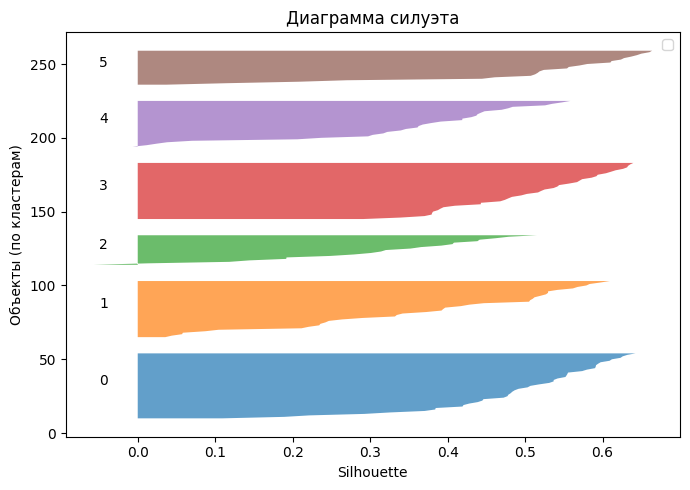


Центры кластеров (в пространстве стандартизованных признаков):


,Age,AnnualIncome(k$),SpendingScore(1-100)
cluster_0,1.004115,-0.198174,-0.024401
cluster_1,-0.468503,-0.096593,-0.086476
cluster_2,0.470312,-0.964775,-0.800498
cluster_3,-0.163343,0.685985,0.839953
cluster_4,0.327160,0.765411,-0.853758
cluster_5,-0.530864,-0.977169,0.703704


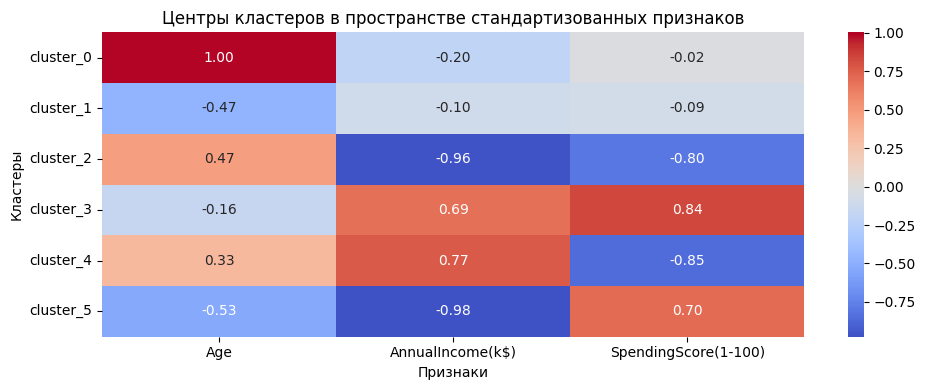


Характеристики кластеров (внутрикластерные расстояния / компактность):


,cluster,size,mean_dist_to_center,std_dist_to_center,within_cluster_SSE
0,0,45,0.481782,0.154681,11.521820
1,1,39,0.489882,0.218783,11.226167
2,2,21,0.623211,0.274504,9.738635
3,3,39,0.481397,0.233039,11.155955
4,4,32,0.630124,0.287809,15.356494
5,5,24,0.428668,0.217135,5.541699



Расстояния между центрами кластеров (евклидовы):


,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5
cluster_0,0.000000,1.477422,1.214476,1.700530,1.440346,1.868992
cluster_1,1.477422,0.000000,1.464561,1.250528,1.401732,1.184773
cluster_2,1.214476,1.464561,0.000000,2.411972,1.736915,1.806967
cluster_3,1.700530,1.250528,2.411972,0.000000,1.765095,1.708718
cluster_4,1.440346,1.401732,1.736915,1.765095,0.000000,2.489674
cluster_5,1.868992,1.184773,1.806967,1.708718,2.489674,0.000000


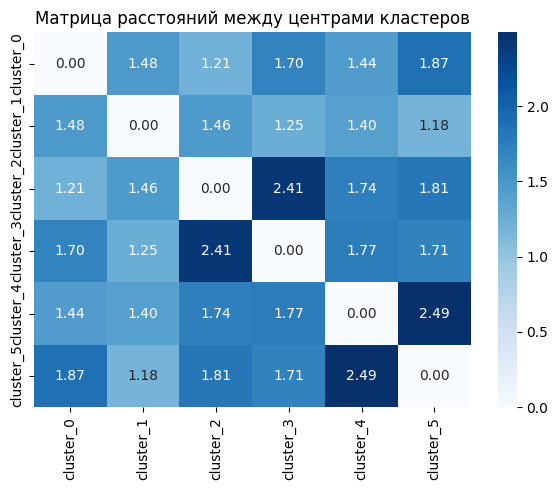


Значимость признаков по кластерам (односторонний ANOVA, KMeans):


,feature,F_stat,p_value
0,Age,88.545562,3.666826e-48
1,AnnualIncome(k$),147.325931,4.568006e-64
2,SpendingScore(1-100),208.893198,4.593251e-76


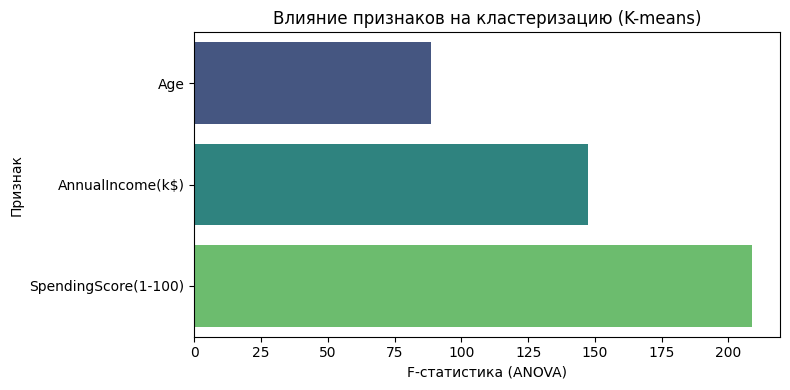

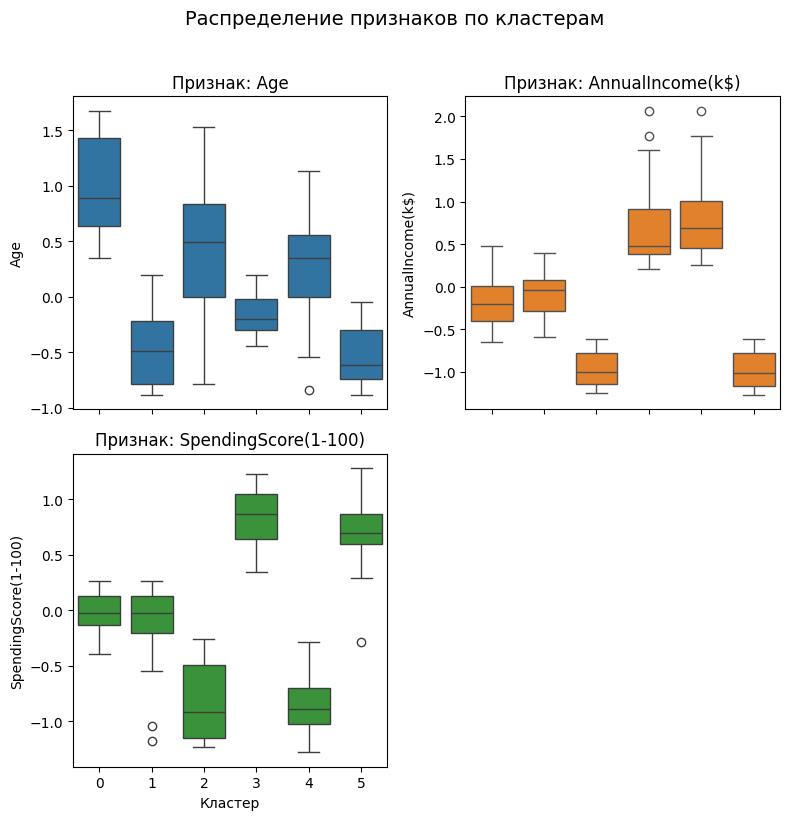

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import (
    silhouette_samples,
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score,
    adjusted_rand_score,
    pairwise_distances,
)
from scipy.stats import f_oneway
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

k = 6

kmeans = KMeans(
    n_clusters=k,
    init="k-means++",
    n_init=10,
    random_state=42,
)
kmeans.fit(X_scaled)
labels = kmeans.labels_


sil_samples = silhouette_samples(X_scaled, labels)
sil = silhouette_score(X_scaled, labels)
ch = calinski_harabasz_score(X_scaled, labels)
db = davies_bouldin_score(X_scaled, labels)

print(f"Метрики KMeans (k = {k}):")
print(f"Средний силуэт           : {sil:.4f}")
print(f"Индекс Калински–Харабаса : {ch:.4f}")
print(f"Индекс Дэвиса–Болдина    : {db:.4f}")

fig, ax = plt.subplots(figsize=(7, 5))

y_lower = 10
for c in range(k):
    sil_c = sil_samples[labels == c]
    sil_c.sort()
    size_c = sil_c.shape[0]
    y_upper = y_lower + size_c

    ax.fill_betweenx(
        np.arange(y_lower, y_upper),
        0, sil_c,
        alpha=0.7,
    )
    ax.text(-0.05, y_lower + 0.5 * size_c, str(c))
    y_lower = y_upper + 10


ax.set_title(f"Диаграмма силуэта")
ax.set_xlabel("Silhouette")
ax.set_ylabel("Объекты (по кластерам)")
ax.legend(loc="best")

plt.tight_layout()
plt.show()


centers = kmeans.cluster_centers_ 

print("\nЦентры кластеров (в пространстве стандартизованных признаков):")
centers_df = pd.DataFrame(centers, columns=X_scaled.columns)
centers_df.index = [f"cluster_{c}" for c in range(k)]
display(centers_df)

plt.figure(figsize=(10, 4))
sns.heatmap(
    centers_df,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0
)
plt.title("Центры кластеров в пространстве стандартизованных признаков")
plt.xlabel("Признаки")
plt.ylabel("Кластеры")
plt.tight_layout()
plt.show()

dist_to_centers = pairwise_distances(X_scaled, centers)

cluster_stats = []
for c in range(k):
    mask = (labels == c)
    n_c = mask.sum()
    if n_c == 0:
        mean_dist = np.nan
        std_dist = np.nan
        sse_c = np.nan
    else:
        dists_c = dist_to_centers[mask, c]
        mean_dist = dists_c.mean()
        std_dist = dists_c.std()
        sse_c = (dists_c ** 2).sum()

    cluster_stats.append({
        "cluster": c,
        "size": n_c,
        "mean_dist_to_center": mean_dist,
        "std_dist_to_center": std_dist,
        "within_cluster_SSE": sse_c,
    })

print("\nХарактеристики кластеров (внутрикластерные расстояния / компактность):")
cluster_stats_df = pd.DataFrame(cluster_stats)
display(cluster_stats_df)

center_dists = pairwise_distances(centers, centers)
center_dists_df = pd.DataFrame(
    center_dists,
    index=[f"cluster_{c}" for c in range(k)],
    columns=[f"cluster_{c}" for c in range(k)]
)

print("\nРасстояния между центрами кластеров (евклидовы):")
display(center_dists_df)

plt.figure(figsize=(6, 5))
sns.heatmap(center_dists_df, annot=True, fmt=".2f", cmap="Blues")
plt.title("Матрица расстояний между центрами кластеров")
plt.tight_layout()
plt.show()


X_df = X_scaled.copy()
X_df["cluster"] = labels

feature_cols = [c for c in X_df.columns if c not in ["cluster"]]

anova_rows = []
for feat in feature_cols:
    groups = [X_df.loc[labels == c, feat] for c in range(k) if (labels == c).sum() > 1]
    if len(groups) > 1:
        F, p = f_oneway(*groups)
    else:
        F, p = np.nan, np.nan
    anova_rows.append({
        "feature": feat,
        "F_stat": F,
        "p_value": p,
    })

anova_df = pd.DataFrame(anova_rows)
print("\nЗначимость признаков по кластерам (односторонний ANOVA, KMeans):")
display(anova_df)
plt.figure(figsize=(8, 4))
sns.barplot(
    data=anova_df,
    x="F_stat",
    y="feature",
    palette="viridis"
)
plt.title("Влияние признаков на кластеризацию (K-means)")
plt.xlabel("F-статистика (ANOVA)")
plt.ylabel("Признак")
plt.tight_layout()
plt.show()


colors = ["tab:blue", "tab:orange", "tab:green", "tab:red",
          "tab:purple", "tab:brown", "tab:pink", "tab:gray"]

n_feats = len(feature_cols)
n_rows = 2
n_cols = int(np.ceil(n_feats / n_rows))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows), sharex=True)
axes = np.array(axes).ravel()

for i, feat in enumerate(feature_cols):
    ax = axes[i]
    sns.boxplot(
        data=X_df,
        x="cluster",
        y=feat,
        ax=ax,
        color=colors[i % len(colors)],
    )
    ax.set_title(f"Признак: {feat}")
    ax.set_xlabel("Кластер")
    ax.set_ylabel(feat)

for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.suptitle("Распределение признаков по кластерам", y=1.02, fontsize=14)
plt.tight_layout()
plt.show()


Проанализируем полученные результаты. 
1. Значение индекса Калински–Харабаса = 134.6023, индекса Дэвиса–Болдина = 0.8283, что указывает на достаточно хорошую кластерную структуру. Высокий CH говорит о том, что центры кластеров достаточно хорошо разнесены, а сами кластеры достаточно компактны. Значение DB немного меньше 1, что характерно для хорошего по качеству разбиения -  кластеры хорошо отделены друг от друга (максимальное расстояние между центрами) и компактны (минимальный размер кластеров)

2. Значение среднего силуэта = 0.4276. Такое значение силуэта показывает умеренно хорошее качество кластеризации. По силуэт-диаграмме видим наибольшие значения силуэта у 5 (~0.67), 0 (~0.65) и 3 (~0.65) кластеров. Кластер 1 средний по силуэту, хуже всего себя показывают кластеры 2 и 4 (в целом виден более низкий средний силуэт).

3. Проанализируем кластеры с помощью таблицы внутрикластерных расстояния и размер кластеров.
Самыми удачными с этой точки зрения выглядят кластеры 0, 3 и особенно 5. Кластер 5 демонстрирует лучшую компактность среди всех — среднее расстояние до центра составляет всего 0.429, что значительно ниже, чем у остальных. При этом он имеет умеренный размер (24 объекта) и самый низкий показатель within-cluster SSE (5.542). Это означает, что объекты в этом кластере плотно сгруппированы вокруг своего центра. Кластеры 0 и 3 также показывают очень хорошие результаты — средние расстояния 0.482 и 0.481 соответственно, что близко к показателю кластера 5. Они имеют бóльшие размеры (45 и 39 объектов), но сохраняют хорошую компактность. Это сбалансированные, хорошо определенные группы. Кластер 1 можно отнести к среднему уровню качества. При размере 39 объектов он имеет среднее расстояние 0.490 и умеренный разброс (std = 0.219). Это нормальный, достаточно компактный кластер, хотя и немного уступает лидерам. Наиболее проблемными оказались кластеры 2 и 4. В них наблюдаются самые высокие средние расстояния до центра (0.623 и 0.630 соответственно) и наибольшие стандартные отклонения (0.275 и 0.288). Особенно показательны высокие значения within-cluster SSE, особенно у кластера 4 (15.356 — почти втрое выше, чем у кластера 5). Это свидетельствует о значительной размытости и возможной неоднородности внутри этих групп.

4. На рисунке представлена диаграмма матрицы расстояний между центрами кластеров. Особенно выделяются кластеры 5 и 3 как самые удаленные от остальных кластеров. Кластер 0 и 2 расположены ближе всего к остальным кластерам.

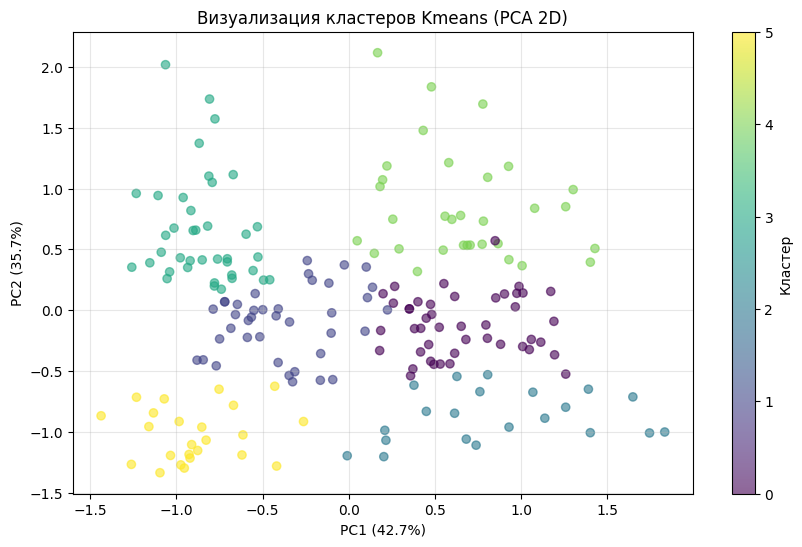

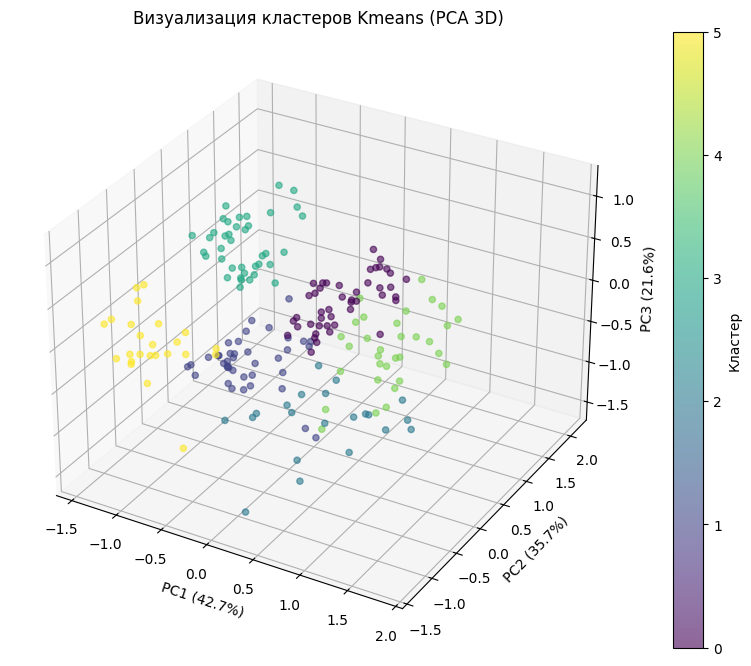

In [ ]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', alpha=0.6)
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
plt.title('Визуализация кластеров Kmeans (PCA 2D)')
plt.colorbar(scatter, label='Кластер')
plt.grid(True, alpha=0.3)
plt.show()

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], 
                    c=labels, cmap='viridis', alpha=0.6)
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
ax.set_zlabel(f'PC3 ({pca.explained_variance_ratio_[2]*100:.1f}%)')
ax.set_title('Визуализация кластеров Kmeans (PCA 3D)')
plt.colorbar(scatter, label='Кластер')
plt.show()

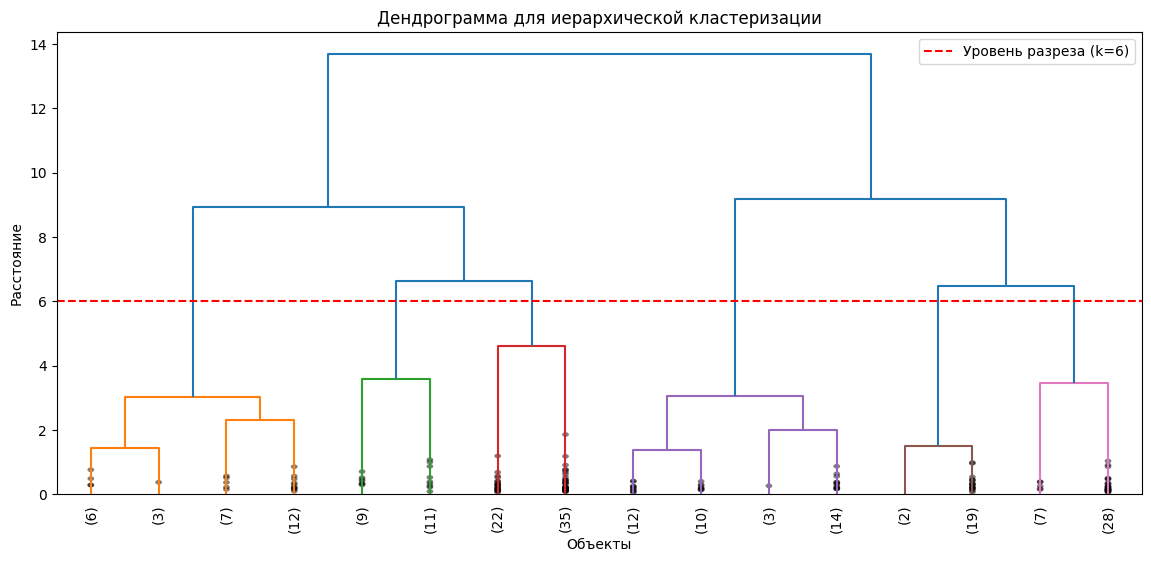

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import AgglomerativeClustering

Z = linkage(X_scaled, method="ward")
plt.figure(figsize=(14, 6))
dendrogram(
    Z,
    truncate_mode="level",   
    p=3,                     
    leaf_rotation=90,
    leaf_font_size=10,
    show_contracted=True,
    color_threshold=6
)
plt.axhline(y=6, color='red', linestyle='--', label='Уровень разреза (k=6)')
plt.title("Дендрограмма для иерархической кластеризации")
plt.xlabel("Объекты")
plt.ylabel("Расстояние")
plt.legend()
plt.show()

In [107]:
from scipy.cluster.hierarchy import fcluster

labels_dendro = fcluster(Z, t=6, criterion="distance")
K_h = len(np.unique(labels_dendro))

print(f"Количество кластеров по дендраграмме: {K_h}")   

Количество кластеров по дендраграмме: 6


In [108]:
from sklearn.cluster import AgglomerativeClustering

agg = AgglomerativeClustering(
    n_clusters=K_h,
    linkage="ward"
)

labels_agg = agg.fit_predict(X_scaled)
sil_agg = silhouette_score(X_scaled, labels_agg)
ch_agg = calinski_harabasz_score(X_scaled, labels_agg)
db_agg = davies_bouldin_score(X_scaled, labels_agg)

print("Метрики иерархической кластеризации:")
print(f"Silhouette score        : {sil_agg:.4f}")
print(f"Calinski–Harabasz index : {ch_agg:.4f}")
print(f"Davies–Bouldin index    : {db_agg:.4f}")

ari_kmeans_vs_agg = adjusted_rand_score(labels, labels_agg)
print(f"ARI (KMeans vs Agglomerative): {ari_kmeans_vs_agg:.4f}")


Метрики иерархической кластеризации:
Silhouette score        : 0.4197
Calinski–Harabasz index : 121.8795
Davies–Bouldin index    : 0.8501
ARI (KMeans vs Agglomerative): 0.7975



Значимость признаков по кластерам (односторонний ANOVA, иерархическая):


,feature,F_stat,p_value
0,Age,77.801211,1.782688e-44
1,AnnualIncome(k$),133.907955,6.286444e-61
2,SpendingScore(1-100),195.957045,8.225415e-74


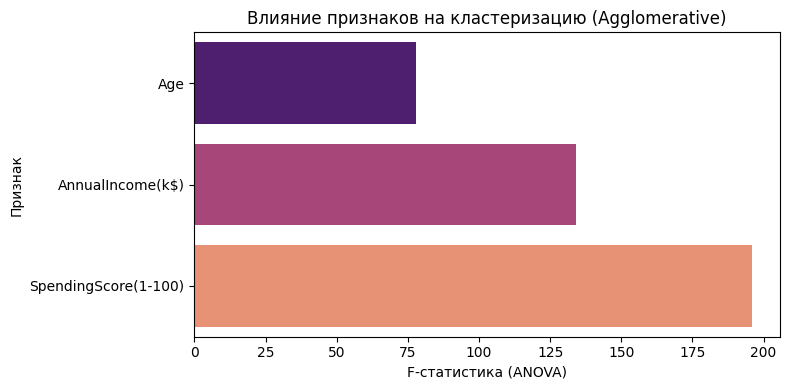

In [ ]:

X_df_hierarchical = X_scaled.copy()
X_df_hierarchical["h_cluster"] = labels_agg

hierarchical_feature_cols = [c for c in X_df_hierarchical.columns if c not in ["h_cluster"]]

hierarchical_anova_rows = []
for feat in hierarchical_feature_cols:
    groups = [X_df_hierarchical.loc[labels_agg == c, feat] 
              for c in range(K_h) if (labels_agg == c).sum() > 1]
    if len(groups) > 1:
        F, p = f_oneway(*groups)
    else:
        F, p = np.nan, np.nan
    hierarchical_anova_rows.append({
        "feature": feat,
        "F_stat": F,
        "p_value": p,
    })

hierarchical_anova_df = pd.DataFrame(hierarchical_anova_rows)
print("\nЗначимость признаков по кластерам (односторонний ANOVA, иерархическая):")
display(hierarchical_anova_df)
plt.figure(figsize=(8, 4))
sns.barplot(
    data=hierarchical_anova_df,
    x="F_stat",
    y="feature",
    palette="magma"
)
plt.title("Влияние признаков на кластеризацию (Agglomerative)")
plt.xlabel("F-статистика (ANOVA)")
plt.ylabel("Признак")
plt.tight_layout()
plt.show()



Условные центры кластеров (Agglomerative):


,Age,AnnualIncome(k$),SpendingScore(1-100)
h_cluster,,,
0,0.841239,-0.168950,-0.055957
1,0.390123,-1.015068,-0.807843
2,-0.163343,0.685985,0.839953
3,0.389771,0.816047,-0.871148
4,-0.586949,-0.119374,-0.130719
5,-0.552616,-0.983040,0.790538


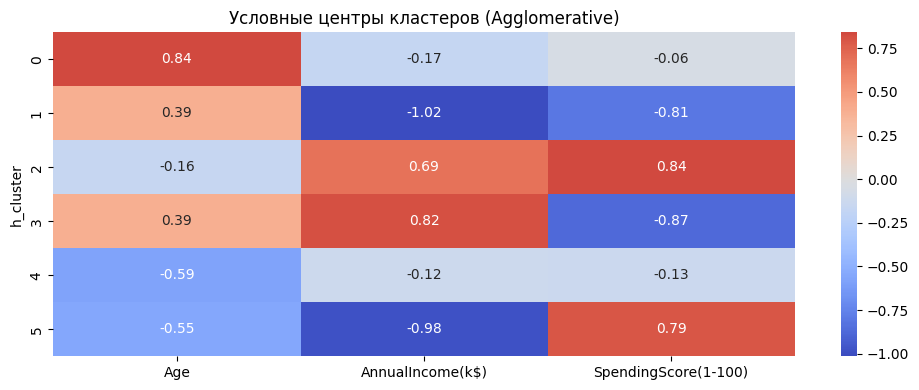


Характеристики кластеров (Agglomerative):


,cluster,size,mean_intra_dist,std_intra_dist,within_cluster_SSE
0,0,57,0.756104,0.372885,2309.183568
1,1,20,0.915905,0.521268,444.240898
2,2,39,0.660300,0.368923,870.164493
3,3,28,0.824336,0.409542,664.247473
4,4,35,0.705595,0.423910,830.015236
5,5,21,0.513709,0.247532,143.399605



Расстояния между центрами кластеров (Agglomerative):


,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5
cluster_0,0.000000,1.218505,1.594601,1.355942,1.431002,1.822671
cluster_1,1.218505,0.000000,2.432106,1.832209,1.488434,1.855965
cluster_2,1.594601,2.432106,0.000000,1.802975,1.330507,1.714532
cluster_3,1.355942,1.832209,1.802975,0.000000,1.541826,2.624121
cluster_4,1.431002,1.488434,1.330507,1.541826,0.000000,1.263255
cluster_5,1.822671,1.855965,1.714532,2.624121,1.263255,0.000000


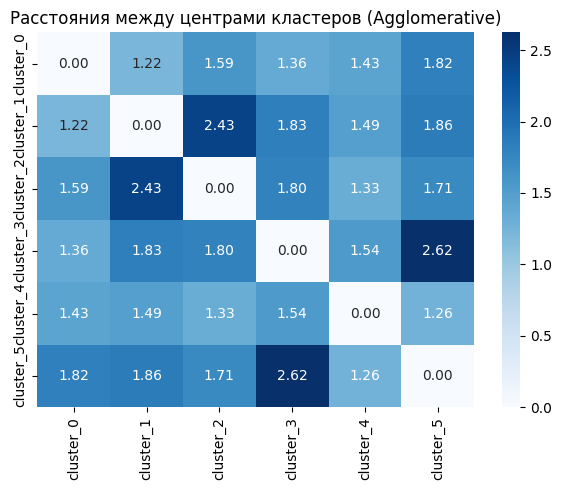

In [ ]:

centers_agg = X_df_hierarchical.groupby("h_cluster").mean()
print("\nУсловные центры кластеров (Agglomerative):")
display(centers_agg)

plt.figure(figsize=(10, 4))
sns.heatmap(
    centers_agg,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0
)
plt.title("Условные центры кластеров (Agglomerative)")
plt.tight_layout()
plt.show()

dist_matrix = pairwise_distances(X_scaled)

cluster_stats_agg = []

for c in range(K_h):
    idx = np.where(labels_agg == c)[0]
    if len(idx) < 2:
        continue

    intra_dists = dist_matrix[np.ix_(idx, idx)]
    mean_intra = intra_dists.mean()
    std_intra = intra_dists.std()
    sse = np.sum(intra_dists ** 2)

    cluster_stats_agg.append({
        "cluster": c,
        "size": len(idx),
        "mean_intra_dist": mean_intra,
        "std_intra_dist": std_intra,
        "within_cluster_SSE": sse
    })

cluster_stats_agg_df = pd.DataFrame(cluster_stats_agg)
print("\nХарактеристики кластеров (Agglomerative):")
display(cluster_stats_agg_df)

center_dist_agg = pairwise_distances(centers_agg)

center_dist_agg_df = pd.DataFrame(
    center_dist_agg,
    index=[f"cluster_{i}" for i in centers_agg.index],
    columns=[f"cluster_{i}" for i in centers_agg.index]
)

print("\nРасстояния между центрами кластеров (Agglomerative):")
display(center_dist_agg_df)

plt.figure(figsize=(6, 5))
sns.heatmap(center_dist_agg_df, annot=True, fmt=".2f", cmap="Blues")
plt.title("Расстояния между центрами кластеров (Agglomerative)")
plt.tight_layout()
plt.show()


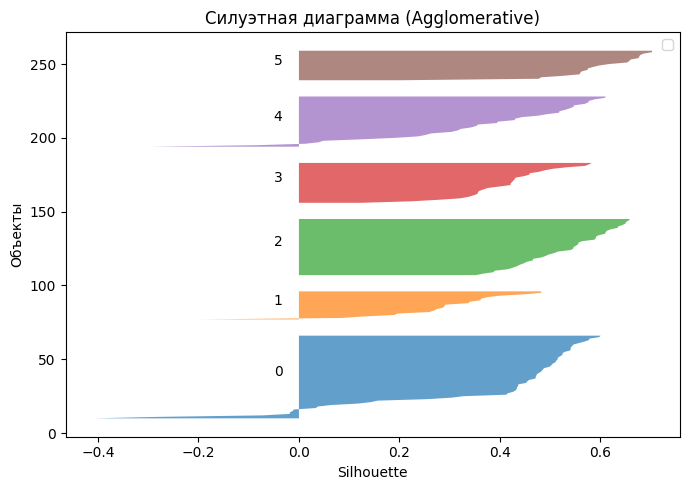

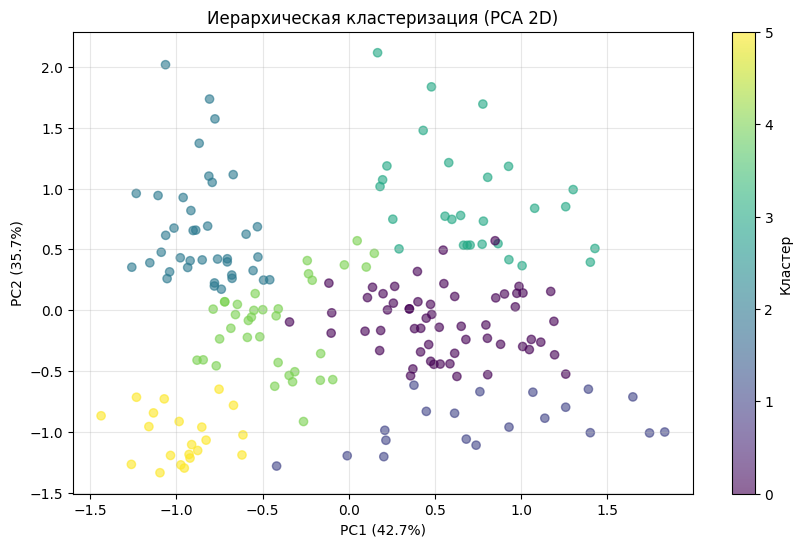

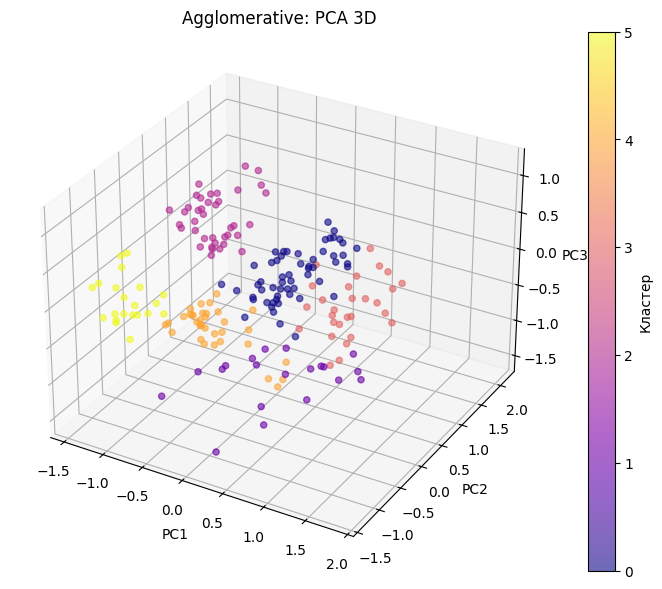

In [ ]:

from sklearn.metrics import silhouette_samples, silhouette_score
sil_samples_agg = silhouette_samples(X_scaled, labels_agg)
sil_avg_agg = silhouette_score(X_scaled, labels_agg)

fig, ax = plt.subplots(figsize=(7, 5))
y_lower = 10

for c in np.unique(labels_agg):
    sil_c = sil_samples_agg[labels_agg == c]
    sil_c.sort()
    size_c = sil_c.shape[0]
    y_upper = y_lower + size_c

    ax.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        sil_c,
        alpha=0.7
    )
    ax.text(-0.05, y_lower + size_c / 2, str(c))
    y_lower = y_upper + 10

ax.set_title("Силуэтная диаграмма (Agglomerative)")
ax.set_xlabel("Silhouette")
ax.set_ylabel("Объекты")
ax.legend()
plt.tight_layout()
plt.show()


from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca_2d = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 6))
plt.scatter(
    X_pca_2d[:, 0],
    X_pca_2d[:, 1],
    c=labels_agg,
    cmap="viridis",
    alpha=0.6
)
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
plt.title("Иерархическая кластеризация (PCA 2D)")
plt.grid(alpha=0.3)
plt.colorbar(label="Кластер")
plt.show()

pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    X_pca[:, 0], X_pca[:, 1], X_pca[:, 2],
    c=labels_agg,
    cmap='plasma',
    alpha=0.6
)

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("Agglomerative: PCA 3D")
plt.colorbar(scatter, label="Кластер")
plt.show()

# Сравнительный анализ решений
Сравним решения кластеризации: K-Means (k=6) и Agglomerative (иерархическая, k=6). Давай проведём сравнительный анализ по ключевым аспектам: метрики качества, распределение признаков, центры кластеров и визуализация.
| Метрика                       | K-Means       | Agglomerative |
| ----------------------------- | ------------- | ------------- |
| Silhouette score              | 0.428         | 0.4197        |
| Calinski–Harabasz index       | 232           | 121.8795      |
| Davies–Bouldin index          | 0.8283        | 0.8501        |

Выводы:

- Silhouette score: K-Means немного лучше сегментирует кластеры (значения ближе к 1 = более выраженные кластеры).
- Calinski–Harabasz index: выше у K-Means, значит кластеры более плотные и отделённые.
- Davies–Bouldin index: меньше у K-Means, значит кластеры менее похожи друг на друга.

## Центры кластеров и распределение признаков
- K-Means: центры кластеров в стандартизированных признаках легко интерпретируются.
- Agglomerative: центры кластеров примерно совпадают, но есть более выраженные отклонения для некоторых признаков.
Вывод: K-Means создаёт более сбалансированные и равномерные кластеры, Agglomerative может формировать кластеры с большей разницей по числу объектов.

## Влияние признаков (ANOVA F-statistic)

- В обоих методах SpendingScore и AnnualIncome(k$) сильнее всего влияют на кластеризацию.
- Age оказывает меньшее влияние, но в Agglomerative её роль чуть выше, что отражается в F-статистике.

In [112]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import pandas as pd

k_values = range(2, 11)          
n_init_values = [5, 10, 20, 50]  

results = []

for n_init in n_init_values:
    for k in k_values:
        kmeans = KMeans(n_clusters=k, n_init=n_init, random_state=42)
        labels = kmeans.fit_predict(X_scaled)
        
        sil = silhouette_score(X_scaled, labels)
        ch = calinski_harabasz_score(X_scaled, labels)
        db = davies_bouldin_score(X_scaled, labels)
        
        results.append({
            "k": k,
            "n_init": n_init,
            "Silhouette": round(sil, 4),
            "Calinski-Harabasz": round(ch, 2),
            "Davies-Bouldin": round(db, 4)
        })

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by=["k", "n_init"]).reset_index(drop=True)

from IPython.display import display
display(results_df)


,k,n_init,Silhouette,Calinski-Harabasz,Davies-Bouldin
0,2,5,0.3279,101.34,1.2926
1,2,10,0.3279,101.34,1.2926
2,2,20,0.3279,101.34,1.2926
3,2,50,0.3279,101.34,1.2926
4,3,5,0.3576,100.40,1.0493
5,3,10,0.3552,100.84,1.0615
6,3,20,0.3552,100.84,1.0615
7,3,50,0.3534,100.84,1.0593
8,4,5,0.4053,125.22,0.9224
9,4,10,0.4053,125.22,0.9224


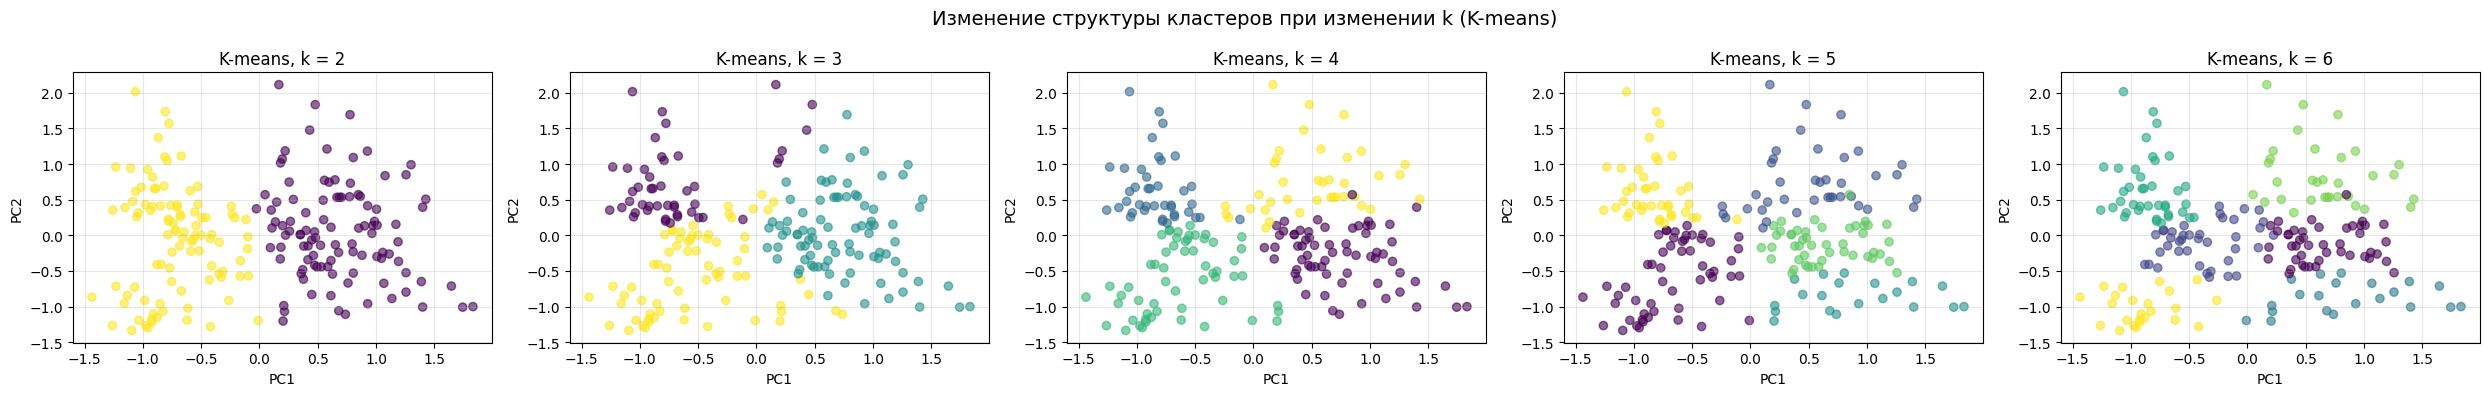

In [113]:
from sklearn.cluster import KMeans

K_range = [2, 3, 4, 5, 6]

fig, axes = plt.subplots(1, len(K_range), figsize=(5 * len(K_range), 4))

for ax, k_test in zip(axes, K_range):
    kmeans = KMeans(
        n_clusters=k_test,
        random_state=42,
        n_init=20
    )
    labels_k = kmeans.fit_predict(X_scaled)

    ax.scatter(
        X_pca_2d[:, 0],
        X_pca_2d[:, 1],
        c=labels_k,
        cmap="viridis",
        alpha=0.6
    )
    ax.set_title(f"K-means, k = {k_test}")
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.grid(alpha=0.3)

plt.suptitle("Изменение структуры кластеров при изменении k (K-means)", fontsize=14)
plt.tight_layout()
plt.show()
